When I first assigned PM to the dataset, I averaged locations at the same lat lon, but forgot to account for sites that lie within the same gridbox.

Here, I fix that following some of the methods in [this blog post](https://james-brennan.github.io/posts/fast_gridding_geopandas/).

In [1]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from shapely.geometry import Point

import metpy
import os

In [6]:
pd.to_datetime('2017-06-13').day_of_year

164

# Figuring it out

In [30]:
df = pd.read_csv(f'/Volumes/Minuet/research/EPA/daily_88101_{2021}.csv', parse_dates=['Date Local'])

In [46]:
df.rename(columns = {
    'Date Local':'time', 
    'Arithmetic Mean': 'PM25',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
}, inplace = True)

keep = ['latitude', 'longitude', 'time', 'PM25']
df.drop(columns=df.columns.difference(keep),inplace=True)
df = df.loc[df.PM25 >= 0]
# df = df.groupby(['time', 'longitude', 'latitude']).mean().reset_index().set_index('time')
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

/var/folders/j8/13gdnhs51_g_jl1wlxj7h3tm0000gn/T/ipykernel_12275/4060788811.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_index(inplace=True)


In [4]:
with xr.open_dataset('/Volumes/Canon/matched/2021/001.nc') as ds:
    ds.load()

In [5]:
proj = ds.metpy.parse_cf('AOD').metpy.cartopy_crs

In [47]:
adf = df.loc['2021-01-01']

In [7]:
transformed = proj.transform_points(src_crs=ccrs.PlateCarree(), x=adf.longitude, y=adf.latitude)

In [8]:
adf['geo_x'] = transformed[:, 0]
adf['geo_y'] = transformed[:, 1]

In [9]:
xfilt = ((adf.geo_x.values >= ds.x.min().item()) & (adf.geo_x.values <= ds.x.max().item()))
yfilt = ((adf.geo_y.values >= ds.y.min().item()) & (adf.geo_y.values <= ds.y.max().item()))

In [10]:
adf = adf[xfilt & yfilt].copy(deep=True)

In [11]:
nearest = ds.sel(x=adf.geo_x.values, y=adf.geo_y.values, method='nearest', tolerance=2000)

In [12]:
adf['x'] = nearest.x.values
adf['y'] = nearest.y.values

In [13]:
avg = adf.reset_index().groupby(['time', 'y', 'x']).mean()

In [14]:
ds['PM25'].values[:] = np.nan

In [15]:
ds['PM25'].count()

<xarray.DataArray 'PM25' ()>
array(0)

In [27]:
for (time, y, x), data in avg.iterrows():
    ds['PM25'].loc[dict(x=x, y=y, time=time)] = data.PM25
ds['PM25'].attrs = {'units': 'micrograms / m^3', 'long_name': 'average of all EPA PM2.5 values within a GOES gridbox'}

In [25]:
ds['PM25'].count()

<xarray.DataArray 'PM25' ()>
array(854)

In this zoomed out version it looks incorrect, but that's just an artifact.

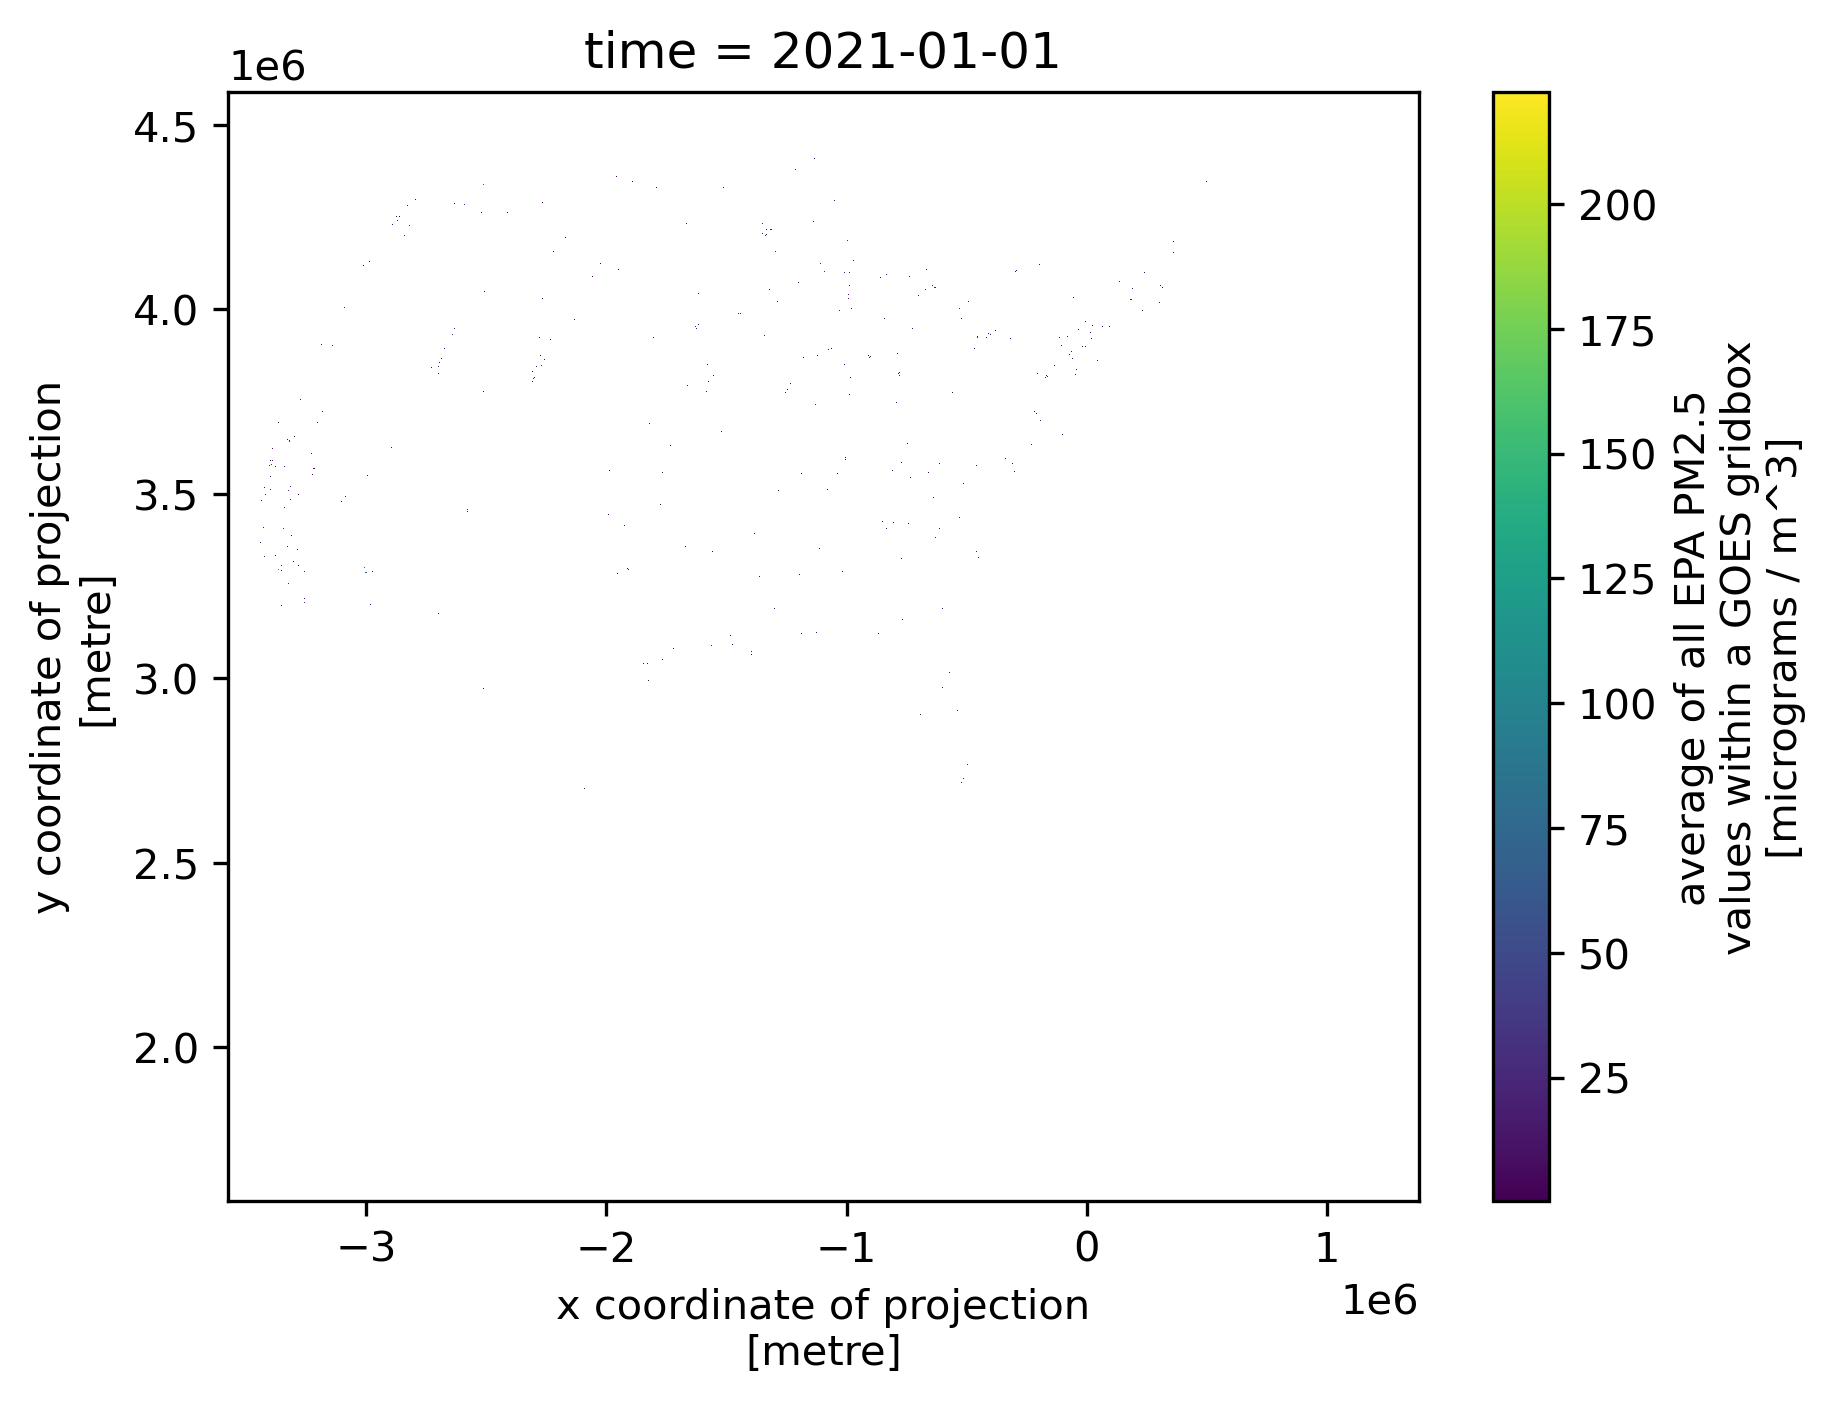

In [28]:
fig, ax = plt.subplots(dpi=300)

ds['PM25'].plot(ax=ax)

Zoom in and we can see more detail, like the three dots in texas

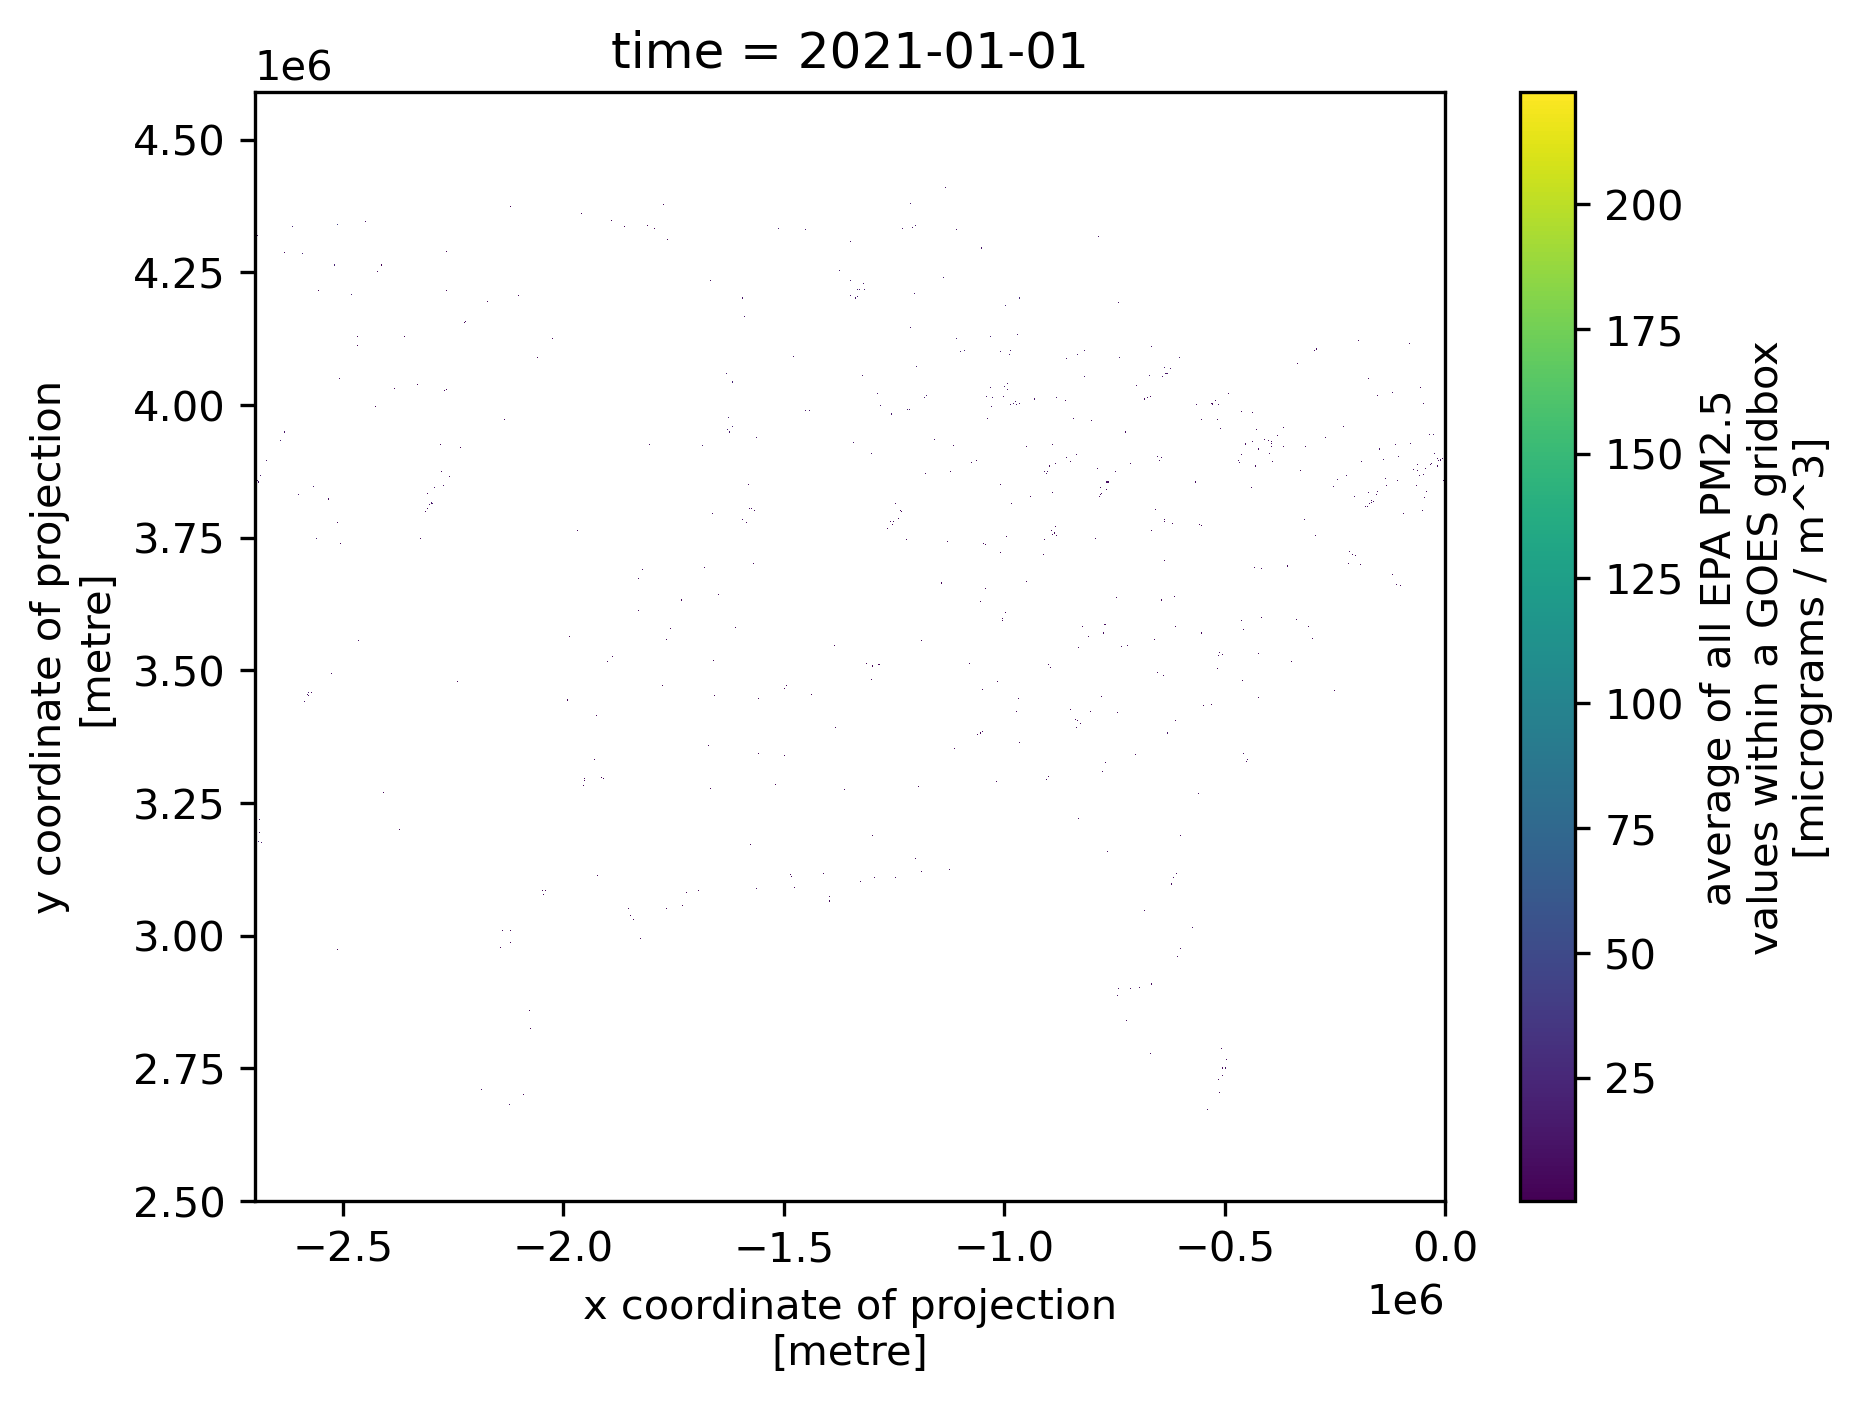

In [29]:
fig, ax = plt.subplots(dpi=300)

ds['PM25'].plot(ax=ax)

ax.set_ylim((2.5e6, 4589199.764884492))
ax.set_xlim((-2.7e6, 0));

as seen here

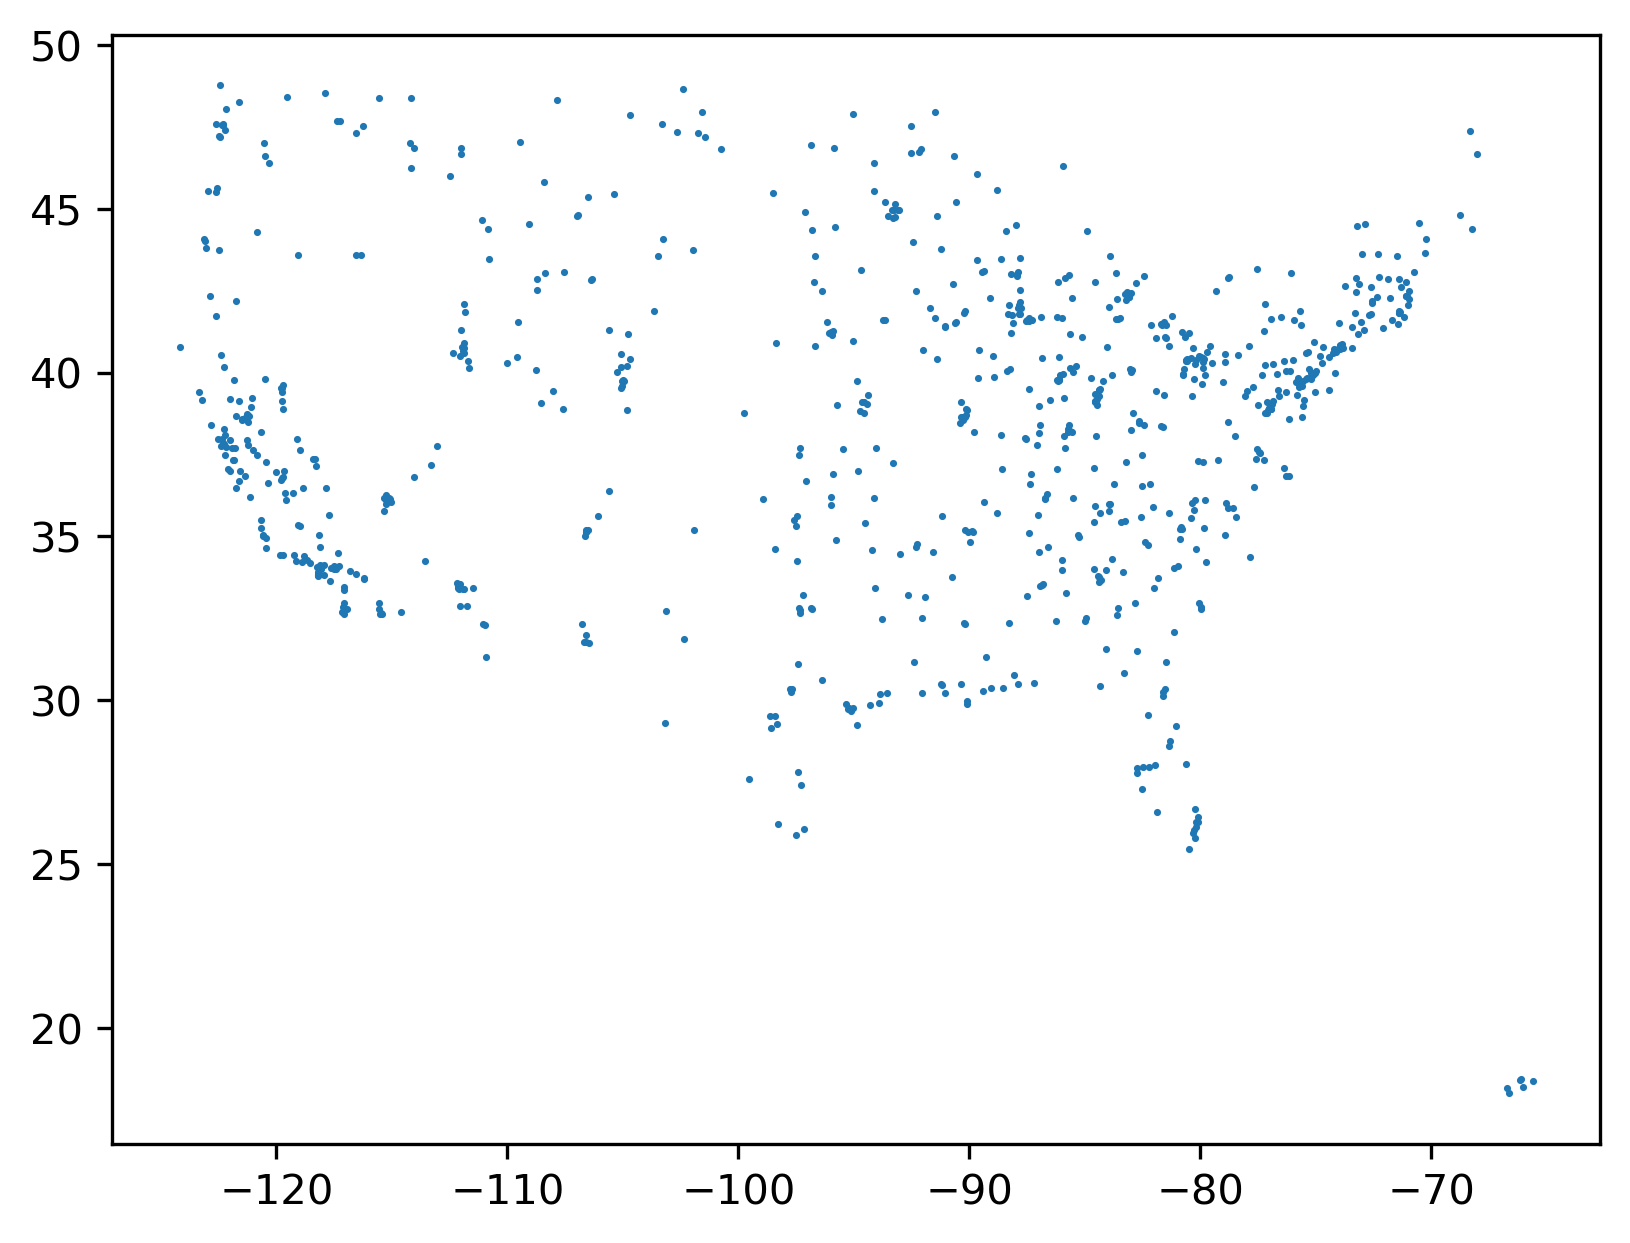

In [20]:
fig, ax = plt.subplots(dpi=300)

ax.scatter(avg.longitude, avg.latitude, s=0.5)

In [22]:
ds

<xarray.Dataset>
Dimensions:                 (time: 1, y: 1500, x: 2474)
Coordinates:
  * time                    (time) datetime64[ns] 2021-01-01
  * y                       (y) float64 4.588e+06 4.586e+06 ... 1.584e+06
  * x                       (x) float64 -3.574e+06 -3.572e+06 ... 1.382e+06
    lat                     (y, x) float64 nan nan nan nan ... 14.64 14.64 14.64
    lon                     (y, x) float64 nan nan nan ... -61.95 -61.93 -61.91
Data variables: (12/16)
    AOD                     (time, y, x) float32 nan nan nan nan ... nan nan nan
    AOD470                  (time, y, x) float32 nan nan nan nan ... nan nan nan
    AE                      (time, y, x) float32 nan nan nan nan ... nan nan nan
    n_snapshots             (time, y, x) float32 nan nan nan nan ... nan nan nan
    goes_imager_projection  int64 0
    u10                     (time, y, x) float32 nan nan nan nan ... nan nan nan
    ...                      ...
    lai_lv                  (time, y, x) float32 nan nan nan nan ... nan nan nan
    skt                     (time, y, x) float32 nan nan nan nan ... nan nan nan
    sp                      (time, y, x) float32 nan nan nan nan ... nan nan nan
    tp                      (time, y, x) float32 nan nan nan nan ... nan nan nan
    blh                     (time, y, x) float32 nan nan ... 1.113e+03 1.111e+03
    PM25                    (time, y, x) float32 nan nan nan nan ... nan nan nan

# Redoing the average

In [35]:
for year in range(2017, 2022):
    df = pd.read_csv(f'/Volumes/Minuet/research/EPA/daily_88101_{year}.csv', parse_dates=['Date Local'])
    df.rename(columns = {
    'Date Local':'time', 
    'Arithmetic Mean': 'PM25',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
    }, inplace = True)

    keep = ['latitude', 'longitude', 'time', 'PM25']
    df.drop(columns=df.columns.difference(keep),inplace=True)
    df = df.loc[df.PM25 >= 0]
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    
    path = f'/Volumes/Canon/matched/{year}'
    pbar = tqdm(sorted([i for i in os.listdir(path) if (i != '.DS_Store') and ('csv' not in i)]))

    for file in pbar:
        pbar.set_description(f'{year} {file}')
        try:
            with xr.open_dataset(os.path.join(path, file)) as ds:
                ds.load()

            proj = ds.metpy.parse_cf('AOD').metpy.cartopy_crs        
            day = pd.to_datetime(ds.time.item())

            adf = df.loc[day.strftime('%Y-%m-%d')]

            transformed = proj.transform_points(src_crs=ccrs.PlateCarree(), x=adf.longitude, y=adf.latitude)
            adf['geo_x'] = transformed[:, 0]
            adf['geo_y'] = transformed[:, 1]

            xfilt = ((adf.geo_x.values >= ds.x.min().item()) & (adf.geo_x.values <= ds.x.max().item()))
            yfilt = ((adf.geo_y.values >= ds.y.min().item()) & (adf.geo_y.values <= ds.y.max().item()))

            adf = adf[xfilt & yfilt].copy(deep=True)

            nearest = ds.sel(x=adf.geo_x.values, y=adf.geo_y.values, method='nearest', tolerance=2000)

            adf['x'] = nearest.x.values
            adf['y'] = nearest.y.values

            avg = adf.reset_index().groupby(['time', 'y', 'x']).mean()

            ds['PM25'].values[:] = np.nan
            for (time, y, x), data in avg.iterrows():
                ds['PM25'].loc[dict(x=x, y=y, time=time)] = data.PM25
            ds['PM25'].attrs = {'units': 'micrograms / m^3', 'long_name': 'average of all EPA PM2.5 values within a GOES gridbox'}

            csv = ds.drop_vars('goes_imager_projection').to_dataframe().reset_index().drop(columns=['x', 'y'])
            csv.dropna(subset=['PM25', 'AOD']).to_csv(os.path.join(path, f'{day.day_of_year:03}.csv'), index=False)
            ds.to_netcdf(os.path.join(path, file))

            ds.close()
            nearest.close()
            del ds, adf, csv, proj, transformed, xfilt, yfilt, nearest, avg
        except:
            print(f'{year} {file}')

  0%|          | 0/209 [00:00<?, ?it/s]

2017 164.nc


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]